In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import time

In [2]:
def ryan_initweight(topo):
    tf.set_random_seed(0)
    params = {}
    for i in range(1, len(topo)):
        W = tf.get_variable("W" + str(i), shape=[topo[i], topo[i-1]], dtype=tf.float64, initializer=tf.contrib.layers.xavier_initializer())
        params['W' + str(i)] = W
        b = tf.get_variable("b" + str(i), shape=[topo[i], 1], dtype=tf.float64, initializer=tf.zeros_initializer())
        params['b' + str(i)] = b
    return params

def ryan_onehot(labels):
    labels = labels.as_matrix()
    temp = []
    for val in labels:
        if val not in temp:
            temp.append(val)
    temp.sort()
    
    result = np.zeros(shape=(len(labels),len(temp)))
    for key, val in enumerate(labels):
        result[key][temp.index(val)] = 1
    return result

def ryan_cal_Z(W,b,A):
    Z = tf.matmul(W, A) + b
    return Z

def ryan_forward(X, params, keep_prob, predict=0):
    A = X
    for i in range(int(len(params)//2)):
        Z = ryan_cal_Z(params['W' + str(i+1)], params['b' + str(i+1)], A)
        if i == int(len(params)//2) - 1:
            A = tf.sigmoid(Z)
            A = tf.nn.softmax(A)

        else:
            if predict == 0:
                A = tf.nn.relu(Z)
                A = tf.nn.dropout(A, keep_prob)
            else:
                A = tf.nn.relu(Z)
    
    return A

# def ryan_cost_func(lastA, Y):
#     t1 = np.multiply(Y, tf.log(lastA))
#     t2 = np.multiply(1.0 - Y, tf.log(1.0 - lastA + 0.00000001)) 
#     cost = -1.0/int(Y.shape[1]) * np.sum(t1 + t2)
#     return cost
    
## Softmax prediction
def ryan_softmax_predict(lastA, Y, params):
    lastA = np.asarray(lastA)
    labels = Y.as_matrix()
    count = 0.0
    softmax_prob = np.zeros(lastA.T.shape)
    pred = []
    
    # softmax with probability
    for i in range(lastA.T.shape[0]):
        temp = np.exp(lastA.T[i])
        softmax_prob[i] = temp/np.sum(temp)
    
    # make prediction
    for i in range(labels.shape[0]):
        pred.append(np.argmax(softmax_prob[i]))
        if(np.argmax(softmax_prob[i]) != labels[i]):
            count += 1
    
    return softmax_prob, pred, 1.0 - count/labels.shape[0], count

In [3]:
start = time.time()
## preprocess data
df_train = pd.read_csv('ex4_train.csv.xls')
df_test = pd.read_csv('ex4_test.csv.xls')
df_train = df_train.drop(['Unnamed: 0'], axis=1)
df_test = df_test.drop(['Unnamed: 0'], axis=1)

X_train = df_train.iloc[:,0:400].T
Y_train = ryan_onehot(df_train['y']).T
Y_train1 = df_train['y']

X_test = df_test.iloc[:,0:400].T
Y_test = df_test['y']

======= 0.3 ======
Train  0.9657142857142857
Test  0.9226666666666666
======= 0.6 ======
Train  0.9854285714285714
Test  0.9339999999999999
======= 0.7 ======
Train  0.9877142857142858
Test  0.9413333333333334
======= 0.8 ======
Train  0.9891428571428571
Test  0.9406666666666667
======= 0.9 ======
Train  0.9908571428571429
Test  0.944


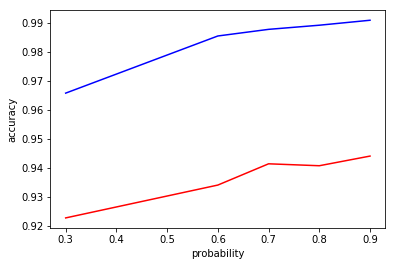

537.3434920310974


In [4]:
## run same model for each keep_prob
# keep_prob = [0.8,0.85,0.91,0.92,0.93,0.94,0.95]
keep_prob = [0.3,0.6,0.7,0.8,0.9]
# keep_prob = [0.5]
accs_train = []
accs_test = []
for i in range(len(keep_prob)):
    X_train_tf = tf.placeholder(tf.float64, shape=(X_train.shape))
    Y_train_tf = tf.placeholder(tf.float64, shape=(Y_train.shape))

    X_test_tf = tf.placeholder(tf.float64, shape=(X_test.shape))
    Y_test_tf = tf.placeholder(tf.float64, shape=(Y_test.shape))


    params = ryan_initweight([400, 300, 25, 10]) #[400, 300, 100, 10]
    lastA = ryan_forward(X_train_tf, params, keep_prob[i])
    #cost = ryan_cost_func(lastA, Y_train_tf)
#     cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y_train_tf,logits=lastA))
    cost = -tf.reduce_mean(Y_train_tf * tf.log(lastA), 1)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
    pred = ryan_forward(X_train_tf, params, 1)
    pred1 = ryan_forward(X_test_tf, params, 1)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for _ in range(500):
            _, para = sess.run([optimizer, params], feed_dict={X_train_tf:X_train, Y_train_tf:Y_train})

#         writer = tf.summary.FileWriter("/Users/huynh/Documents/workspace/258/log/4log/", sess.graph)
#         writer.close()
        predict_train = sess.run(pred, feed_dict={X_train_tf:X_train})
        predict_test = sess.run(pred1, feed_dict={X_test_tf:X_test})
       
    softmax_matrix, num_pred, accuracy, count = ryan_softmax_predict(predict_train, Y_train1, para)
    softmax_matrix1, num_pred1, accuracy1, count1 = ryan_softmax_predict(predict_test, Y_test, para)
    
    accs_train.append(accuracy)
    accs_test.append(accuracy1)
    print("=======", keep_prob[i], "======")
    print("Train ", accuracy)
    print("Test ", accuracy1)
    tf.reset_default_graph()

## Draw graph
plt.plot(keep_prob, accs_train, "b-",keep_prob, accs_test, "r-", )
plt.xlabel('probability')
plt.ylabel('accuracy')
plt.show()
end = time.time()
print("time used: ", end-start ," seconds")

In [5]:
print("time used: ", end-start ," seconds")

time used:  537.3434920310974  seconds
